In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import statsmodels.api as sm
from scipy.spatial import ConvexHull
from scipy.stats import normaltest, shapiro, anderson, norm, t as t_stud
from sklearn.decomposition import PCA

In [2]:
matplotlib_inline.backend_inline.set_matplotlib_formats('png', 'pdf')
plt.rcParams.update({'font.size': 12,
                     'xtick.labelsize' : 12,
                     'ytick.labelsize' : 12,
                     'axes.grid': False})

my_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 

---

# Load Data

In [3]:
# we use the dataset without duplicated columns

X_train = pd.read_csv('X_train_no_red.csv', header = 0)
y_train = pd.read_fwf('y_train.txt', header = None)
X_test = pd.read_csv('X_test_no_red.csv', header = 0)
y_test = pd.read_fwf('y_test.txt', header = None)

In [4]:
X_train.columns = X_train.columns.astype(int)
X_test.columns = X_test.columns.astype(int)

In [5]:
with open("features.txt") as f:
    lines = f.read().splitlines() 

In [6]:
features = {}
for line in lines:
    idx, name = line.split()
    features[int(idx)-1] = name

In [7]:
with open('activity_labels.txt') as f:
    lines = f.read().splitlines()

activities = {}
for line in lines:
    label, activity = line.split()
    activities[int(label)] = activity

---

# Normal distributions

https://towardsdatascience.com/normality-tests-in-python-31e04aa4f411

We can already get an idea of which variables have a (pseudo)-normal distribution by looking at the histograms. To be "sure", we run some normality tests taken from the scipy library. These functions test the null hypothesis that a variable comes from a normal distribution, thus if the p-values is smaller than the significance level, the attribute under investigation can be considered non normal.

In [8]:
# significance level

alpha = 0.01

## D’Agostino and Pearson’s test

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html#scipy-stats-normaltest

It is a specific test for normality.

In [9]:
# It is based on D’Agostino and Pearson’s test that combines skew 
# and kurtosis to produce an omnibus test of normality.

stats, pvalues = normaltest(X_train)

In [10]:
mask = pvalues > alpha
DP_normal_attr = X_train.columns[mask]

In [11]:
DP_normal_attr.size

11

In [12]:
DP_normal_attr

Int64Index([36, 119, 148, 156, 197, 212, 251, 451, 452, 453, 512], dtype='int64')

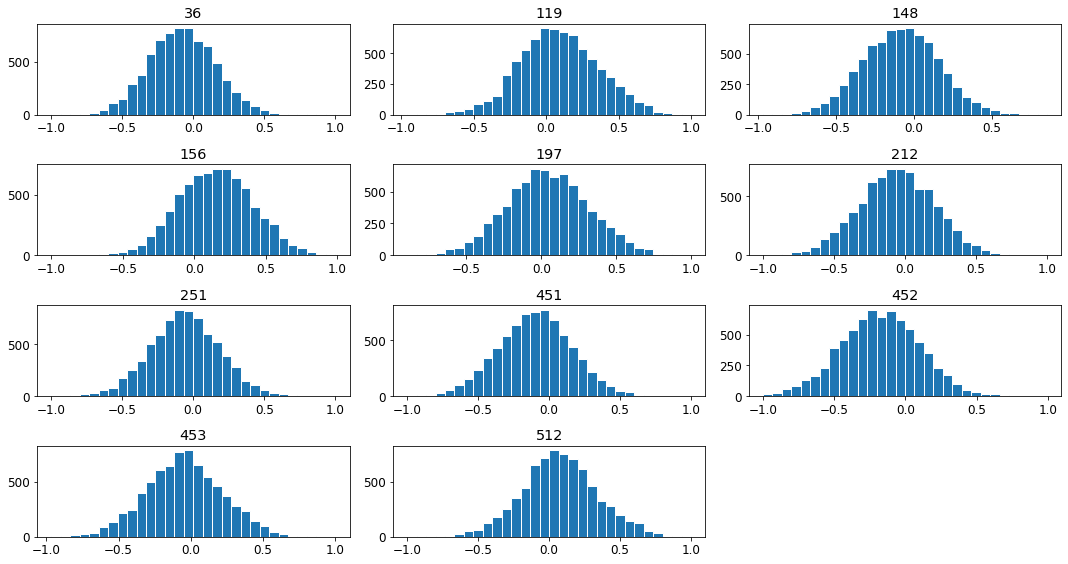

In [13]:
X_train[DP_normal_attr].hist(grid = False, bins = 30, edgecolor = 'w',
                             figsize=(15,8))
plt.tight_layout()
plt.show()

In [14]:
for col in DP_normal_attr:
    print(features[col])

tBodyAcc-arCoeff()-Z,4
tBodyAccJerk-correlation()-Y,Z
tBodyGyro-arCoeff()-X,4
tBodyGyro-arCoeff()-Z,4
tBodyGyroJerk-correlation()-X,Y
tBodyAccMag-arCoeff()4
tBodyGyroMag-arCoeff()4
fBodyGyro-meanFreq()-X
fBodyGyro-meanFreq()-Y
fBodyGyro-meanFreq()-Z
fBodyAccMag-meanFreq()


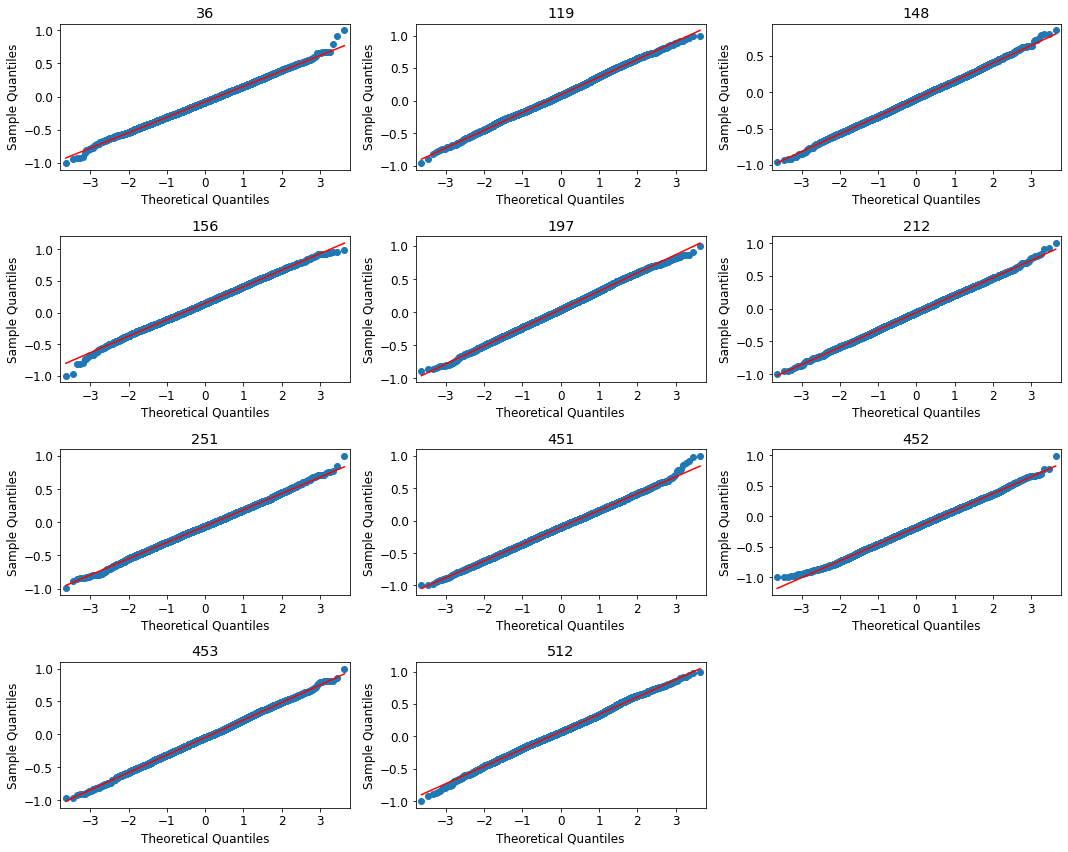

In [15]:
# Q-Q plot

fig = plt.figure(figsize = (15,12), tight_layout = True)

for i, col in enumerate(DP_normal_attr,1):
    ax = fig.add_subplot(4, 3, i)
    sm.graphics.qqplot(X_train[col].values, line = 's', ax = ax)
    ax.set_title(f'{col}')
plt.show()

## Shapiro-Wilk test

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html?highlight=shapiro#scipy-stats-shapiro

It is a specific test for normality.

In [16]:
stats = []
pvalues = []

for col in X_train.columns:
    s, p = shapiro(X_train[col])
    stats.append(s)
    pvalues.append(p)

stats = np.array(stats)
pvalues = np.array(pvalues)

C:\Users\simon\anaconda3\envs\myenv\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [17]:
mask = pvalues > alpha
shapiro_normal_attr = X_train.columns[mask]

In [18]:
shapiro_normal_attr.size

11

In [19]:
shapiro_normal_attr

Int64Index([36, 148, 156, 192, 197, 212, 238, 251, 451, 452, 453], dtype='int64')

In [20]:
# new normal attributes

set(list(shapiro_normal_attr)) - set(list(DP_normal_attr))

{192, 238}

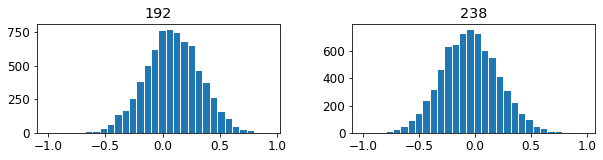

In [21]:
X_train[[192, 238]].hist(grid = False, bins = 30, edgecolor = 'w',
                             figsize=(10,2))
plt.show()

In [22]:
for col in [192, 238]:
    print(features[col])

tBodyGyroJerk-arCoeff()-Y,4
tBodyAccJerkMag-arCoeff()4


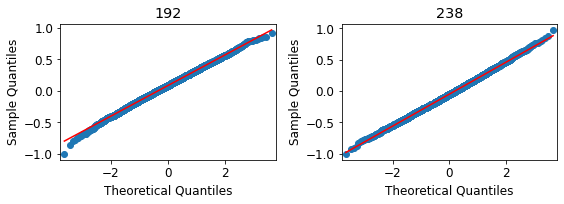

In [23]:
fig = plt.figure(figsize = (8,3), tight_layout = True)
for i, col in enumerate([192, 238], 1):
    ax = fig.add_subplot(1, 2, i)
    sm.graphics.qqplot(X_train[col], line = 's', ax = ax)
    ax.set_title(str(col))
plt.show()

## Anderson test

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html#scipy-stats-anderson

The Anderson-Darling test tests the null hypothesis that a sample is drawn from a population that follows a particular distribution. By default it perform the test for the normal distribution.

In [24]:
stats = []
critical_values = []

for col in X_train.columns:
    s, cv, _ = anderson(X_train[col]) # cv is the array of critical values
    stats.append(s)
    critical_values.append(cv[-1]) # critical value for 1% sign. lvl

stats = np.array(stats)
critical_values = np.array(critical_values)

In [25]:
mask = stats < critical_values
anderson_normal_attr = X_train.columns[mask]

In [26]:
anderson_normal_attr.size

12

In [27]:
anderson_normal_attr

Int64Index([32, 36, 148, 152, 156, 192, 197, 212, 238, 251, 451, 452], dtype='int64')

In [28]:
# new normal attributes

set(list(anderson_normal_attr)) - set(list(DP_normal_attr)) - set(list(shapiro_normal_attr))

{32, 152}

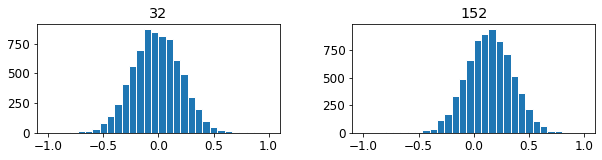

In [29]:
X_train[[32, 152]].hist(grid = False, bins = 30, edgecolor = 'w',
                             figsize=(10,2))
plt.show()

In [30]:
for col in [32, 152]:
    print(features[col])

tBodyAcc-arCoeff()-Y,4
tBodyGyro-arCoeff()-Y,4


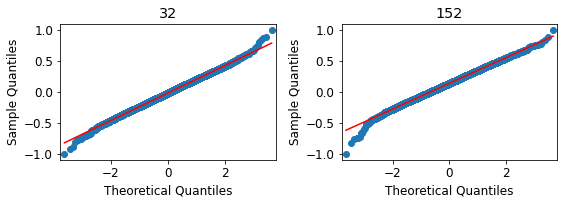

In [31]:
fig = plt.figure(figsize = (8,3), tight_layout = True)
for i, col in enumerate([32, 152], 1):
    ax = fig.add_subplot(1,2,i)
    sm.graphics.qqplot(X_train[col], line = 's', ax = ax)
    ax.set_title(str(col))
plt.show()

---

Let's consider all the unique attributes find by all the previous methods. 

In [32]:
normal_attributes = set(list(anderson_normal_attr)) | set(list(DP_normal_attr)) | set(list(shapiro_normal_attr))
normal_attributes = np.array(sorted(list(normal_attributes)))

In [33]:
normal_attributes.size

15

# Univariate Gaussian Distribution

## Iterative Grubbs' Test for Outlier detection

In [34]:
def grubbs(data, alpha: 'significance level', side: '{left, right, both}' = 'both'):
    def both(alpha, n):
        return 1 - alpha / (2*n)
    def left(alpha, n):
        return alpha
    def right(alpha, n):
        return 1 - alpha / n
        
    if side == 'both': 
        f = both
    elif side == 'left': 
        f = left
    elif side == 'right': 
        f = right 
    outlier_idx = []
    X = data.copy()
    n = len(X)
    while True:
        # t is the f(alpha, n)-quantile of the t-distribution 
        # with n-2 degrees of freedom
        t = t_stud.ppf(q = f(alpha, n), df = n-2) 
        critical_value = ((n-1) / np.sqrt(n)) * (np.sqrt(t**2 / (n-2 + t**2)))
        Z = (X - np.nanmean(X)) / np.nanstd(X, ddof = 1)
        z_max_idx = np.nanargmax(abs(Z))
        z_max = Z[z_max_idx]
        if z_max > critical_value:
            outlier_idx.append(z_max_idx)
            X[z_max_idx] = np.nan
            n -= 1
        else: break
    return outlier_idx

In [35]:
outliers = set()
for col in normal_attributes:
    anomalies = set(grubbs(X_train[col].values, 0.05))
    outliers.update(anomalies)

In [36]:
outlier_idx = np.array(sorted(list(outliers)))
outlier_idx.size

2

In [37]:
X_train[normal_attributes].loc[outlier_idx, :]

,32,36,119,148,152,156,192,197,212,238,251,451,452,453,512
2937,0.839213,1.000000,-0.581730,0.616178,0.518275,0.820118,0.573449,-0.620592,0.595495,-0.460260,0.285626,-0.769633,-0.381258,-0.011366,0.031190
4599,1.000000,-0.032621,0.408963,0.156018,0.159076,0.779934,-0.079092,-0.110181,0.584078,0.302753,-0.186502,0.053155,-0.170627,-0.697421,-0.324432


## Likelihood Approach

In [159]:
# very slow

def likelihood_outliers(col, lambd, th):
    def norm_dist_(x, mu, std): # norm.pdf from scipy is too slow
        return 1/(np.sqrt(2*np.pi)*std) * np.e**(-((x-mu)**2)/(2*std**2))
    def ll_(M, A, lamb):
        sizeA = len(A)
        sumA = 0 if sizeA == 0 else np.log(1/sizeA) * sizeA
        mu = M.mean()
        std = M.std(ddof = 1)
        sumM = np.sum([np.log(norm_dist_(el, mu, std)) for el in M])
        return M.size * np.log(1-lambd) + sumM + sizeA * np.log(lambd) + sumA
        
    M_t = col.copy()
    delta_lst= []
    anomaly_idx = []
    A_t = []
    ll_t = ll_(M_t, A_t, lambd)
    for i, x in enumerate(col):
        A_t1 = A_t.copy()
        A_t1.append(x)
        try:
            M_t1 = np.hstack((M_t[:i], M_t[i+1:]))
        except IndexError:
            M_t1 = M_t[:i]
        ll_t1  = ll_(M_t1, A_t1, lambd)
        delta = ll_t1 - ll_t
        if delta > th:
            anomaly_idx.append(i)
            M_t = M_t1
            A_t = A_t1
            ll_t = ll_t1
            delta_lst.append(delta)
    return delta_lst, anomaly_idx

In [161]:
deltas = []
lambd = 0.01 # fraction of outliers in the training set
th = 3
outliers_idx_lh = set()
for col in normal_attributes:
    delta, idx = likelihood_outliers(X_train[col].values, lambd, th)
    anomalies = set(idx)
    outliers_idx_lh.update(anomalies)
    deltas.append(delta)

In [164]:
deltas

[[4.632650454868099, 4.070070437023446],
 [4.053087209443703, 4.261820127333721],
 [],
 [],
 [3.654550215488598, 4.016047848459152, 7.797564923705977],
 [4.637254023575224],
 [4.8732655282784805],
 [],
 [],
 [],
 [4.222379407139215],
 [4.007436485462563],
 [4.0492559060596705],
 [],
 [3.0763384484907874]]

In [162]:
outliers_idx_lh

{579, 1041, 1904, 1980, 2598, 2911, 2936, 3874, 3890, 4075, 4598, 4763, 5140}

In [163]:
len(outliers_idx_lh)

13

# Multivariate Gaussian Distribution

In [41]:
def mahalanobis(X):
    if isinstance(X, type(pd.DataFrame())):
        X = X.values
    cov_mtx = np.cov(X.T, ddof = 1) # covariance matrix among variables
    iv_cov_mtx = np.linalg.inv(cov_mtx) # inverted covariance matrix
    scarti = X - X.mean(axis = 0)
    mahal_mtx = np.dot(np.dot(scarti, iv_cov_mtx), scarti.T)
    return mahal_mtx.diagonal() 

In [42]:
mahal = mahalanobis(X_train[normal_attributes])

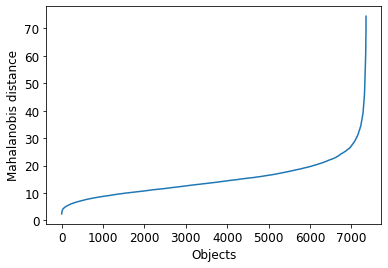

In [43]:
plt.plot(range(mahal.size), np.sort(mahal))
plt.ylabel('Mahalanobis distance')
plt.xlabel('Objects')
plt.show()

In [44]:
# 10 highest mahalanobis distances

for dist in np.sort(mahal)[::-1][:10]:    
    print(dist)

74.4385074248267
68.83295482659952
67.48960300392342
67.28609283885483
64.82197232952649
64.64259592767495
63.786583222589336
62.73953917724864
60.56626809502597
59.56089986010012


For instance, we could consider the 4 objects with the highest distance from the center of the multivariate gaussian distribution as outliers

In [45]:
outlier_idx = np.argsort(mahal)[::-1][:4]

In [46]:
X_train.loc[outlier_idx]

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
1813,-0.420806,-0.108435,0.143614,-0.431167,-0.481365,-0.269445,-0.426237,-0.469722,-0.224431,-0.874314,...,-0.238026,-0.321543,-0.684641,-0.095491,-0.086123,-0.486630,0.406394,0.392280,-0.190777,-0.791983
2911,0.324780,0.076459,0.203528,-0.961258,-0.696918,-0.399352,-0.962968,-0.654961,-0.299325,-0.891630,...,-0.323305,-0.262205,-0.650140,0.101415,0.060234,0.104963,0.108689,-0.765504,0.157034,0.175669
5140,0.303768,0.024768,-0.111032,-0.819078,-0.179662,-0.615672,-0.819035,-0.154121,-0.570682,-0.783548,...,-0.389456,-0.228999,-0.620349,0.428585,0.057584,0.028541,0.096503,0.929237,0.478157,-0.647105
2937,0.260018,-0.008491,-0.117588,-0.935685,-0.670521,-0.875247,-0.959882,-0.805597,-0.907493,-0.892596,...,-0.563006,0.783258,0.551519,0.351286,0.079468,0.329166,0.006809,-0.885412,0.113755,0.100170


# Depth-based Approaches

The time complexity required by this approach on a dataset with 561 features is too high, thus we apply it on the 2D PCA-reduced  dataset.

In [47]:
X_train_pca = PCA(2, random_state = 5).fit_transform(X_train)

In [51]:
hull = ConvexHull(X_train_pca)

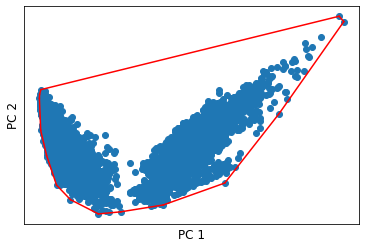

In [49]:
plt.figure(figsize = (6,4))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
for edge in hull.simplices:
    plt.plot(X_train_pca[edge, 0], X_train_pca[edge, 1], 'r')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

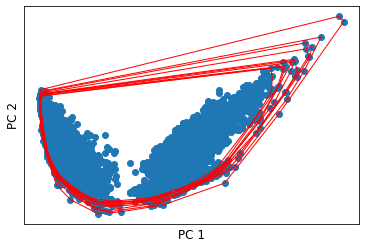

In [50]:
# plot convex hull for the first 10 depths

plt.figure(figsize = (6,4))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
df = X_train_pca.copy()
for depth in range(10):
    conv_hull = ConvexHull(df)
    edges = conv_hull.simplices
    for edge in edges:
        plt.plot(df[edge, 0], df[edge, 1], 'r', lw = 1)
    df = np.delete(df, edges, axis = 0)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

In [165]:
# we could discard the alements at depth 1

outliers_indices = set(hull.simplices.ravel())

Let's put all the outliers together and remove them from the data set

In [166]:
outliers_indices.update({2937, 4599, 1813, 2911, 5140, 2937}) # Grubbs
outliers_indices.update(set(outliers_idx_lh))

In [168]:
len(outliers_indices)

30

In [169]:
df = pd.read_csv('.\Lia\X_train_senzaoutlier_lia.csv', header = 0, index_col = 0)

In [172]:
new_idx = set(df.index) - set(outliers_indices)
len(new_idx)

7274

In [173]:
df = df.loc[list(new_idx), :]
df.to_csv('X_train_wo_outliers.csv')

In [176]:
df.columns = X_train.columns
df.to_csv('X_train_wo_outliers_num.csv')

In [183]:
y_train = y_train.loc[list(new_idx), :]
y_train.to_csv('y_train_wo_outliers_num.csv')